In [122]:
!pip install optuna

In [123]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBRegressor
import optuna
import joblib
import warnings
warnings.filterwarnings("ignore")

In [124]:
df = pd.read_csv("movie_data.csv", encoding='latin-1')

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [126]:
df.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [127]:
df.dropna(inplace=True)

In [128]:
print(df.shape)
print("-"*20)
print(df.isna().sum())
print("-"*20)
print(df.duplicated().sum())
print("-"*20)
df.info()

(5659, 10)
--------------------
Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64
--------------------
0
--------------------
<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5659 non-null   object 
 1   Year      5659 non-null   object 
 2   Duration  5659 non-null   object 
 3   Genre     5659 non-null   object 
 4   Rating    5659 non-null   float64
 5   Votes     5659 non-null   object 
 6   Director  5659 non-null   object 
 7   Actor 1   5659 non-null   object 
 8   Actor 2   5659 non-null   object 
 9   Actor 3   5659 non-null   object 
dtypes: float64(1), object(9)
memory usage: 486.3+ KB


In [129]:
df.nunique()

Name        5385
Year          91
Duration     174
Genre        376
Rating        83
Votes       2027
Director    2431
Actor 1     1960
Actor 2     2321
Actor 3     2556
dtype: int64

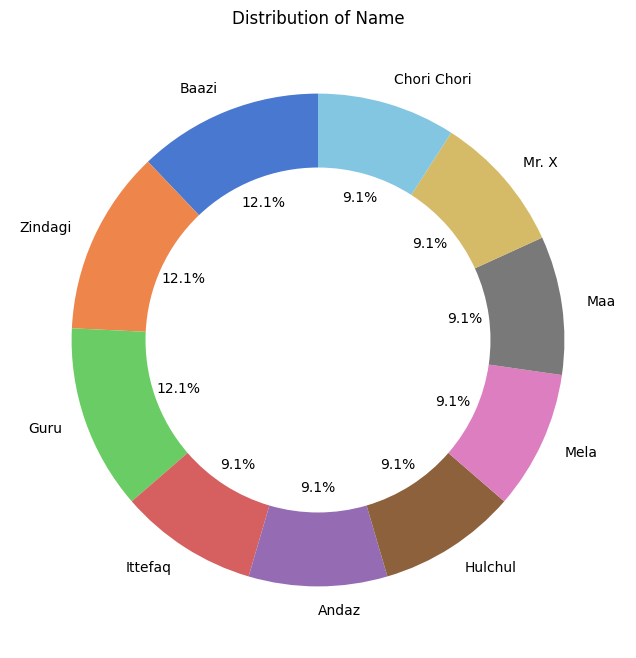

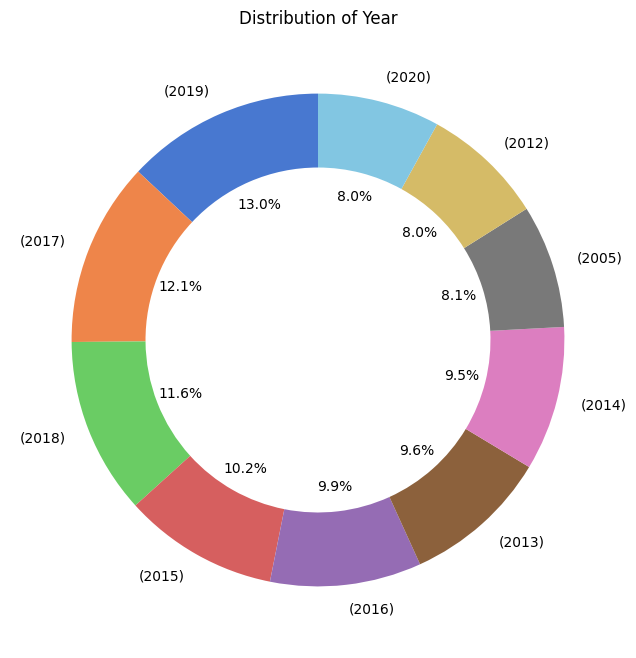

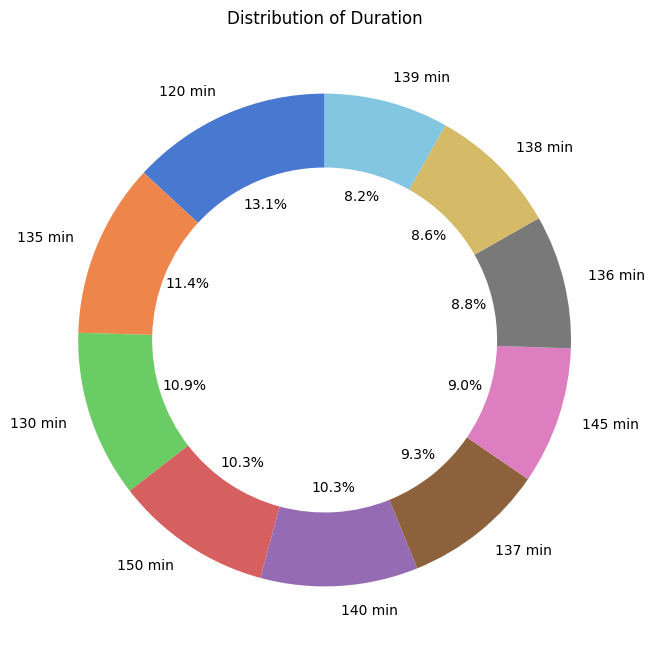

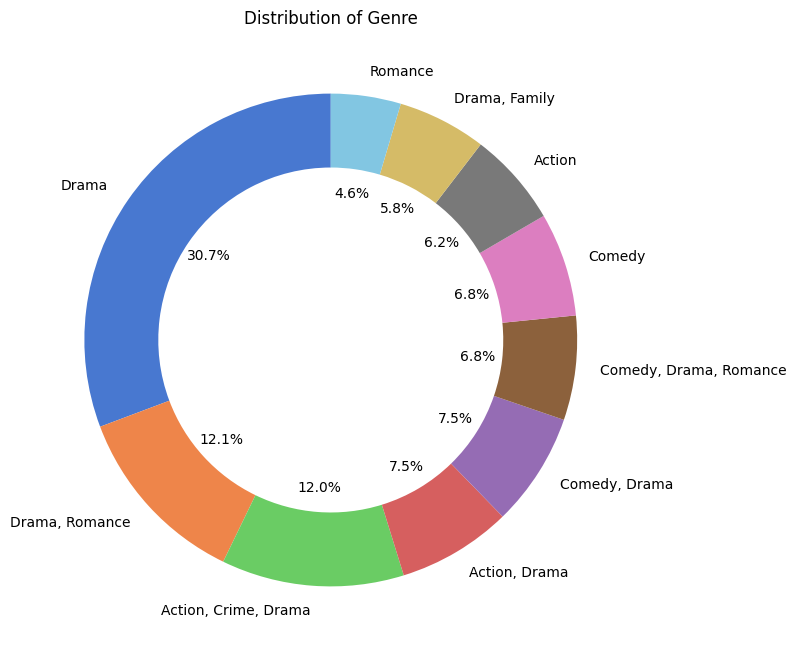

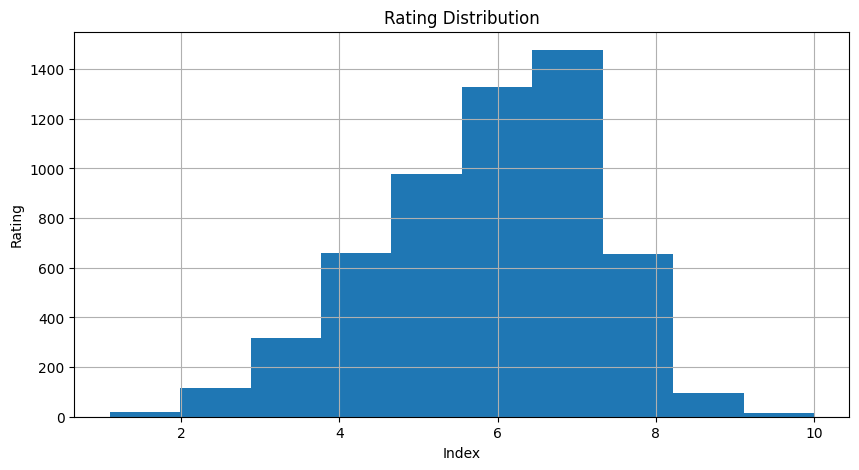

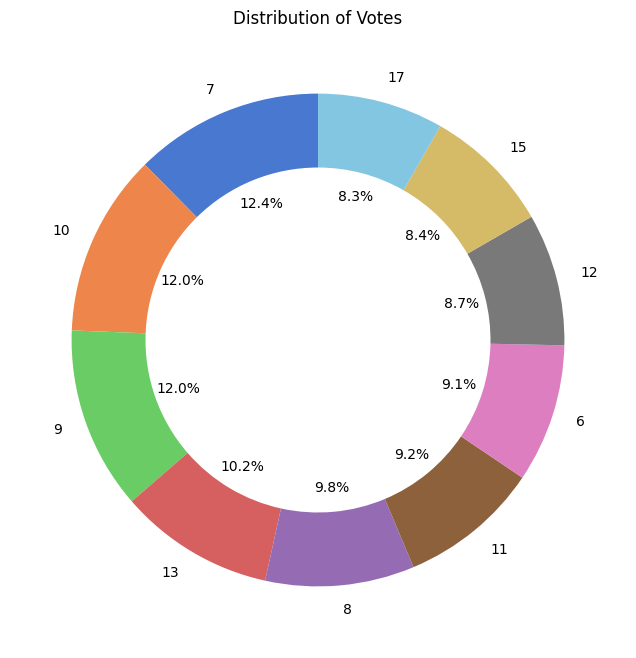

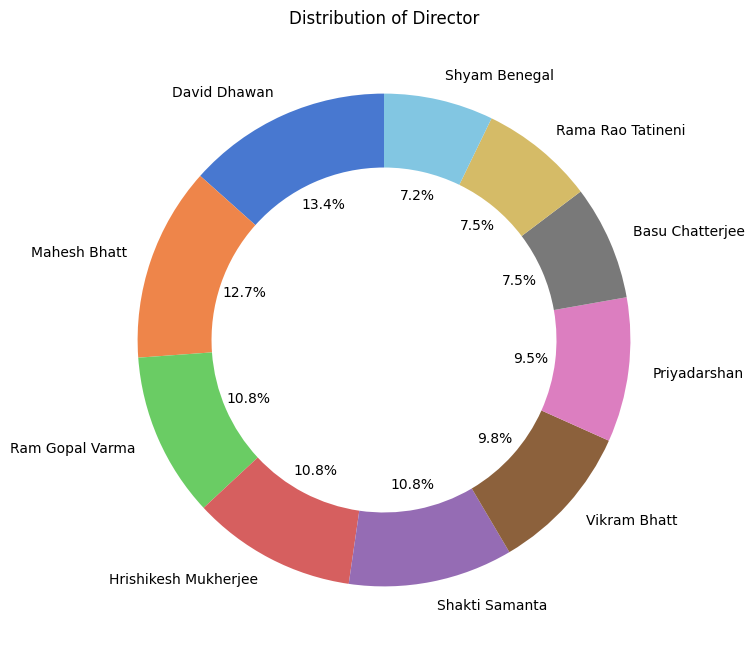

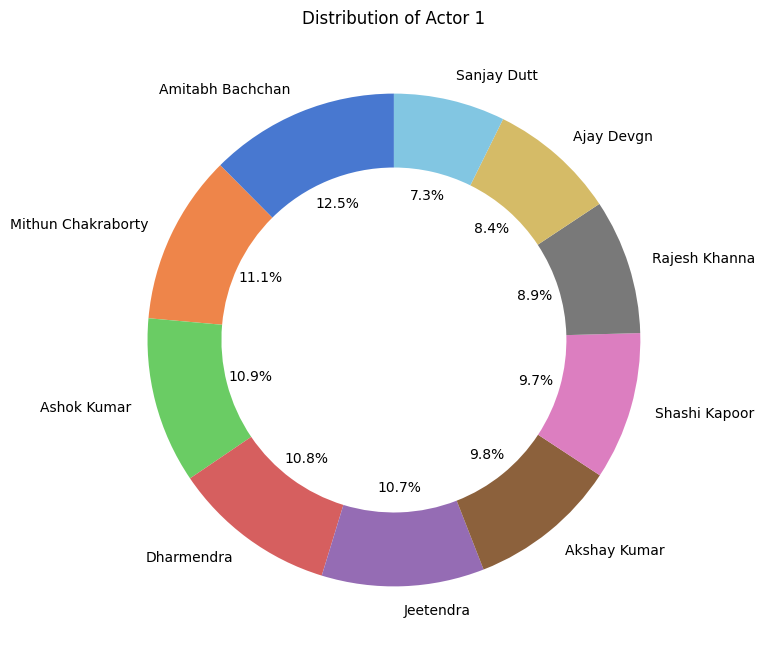

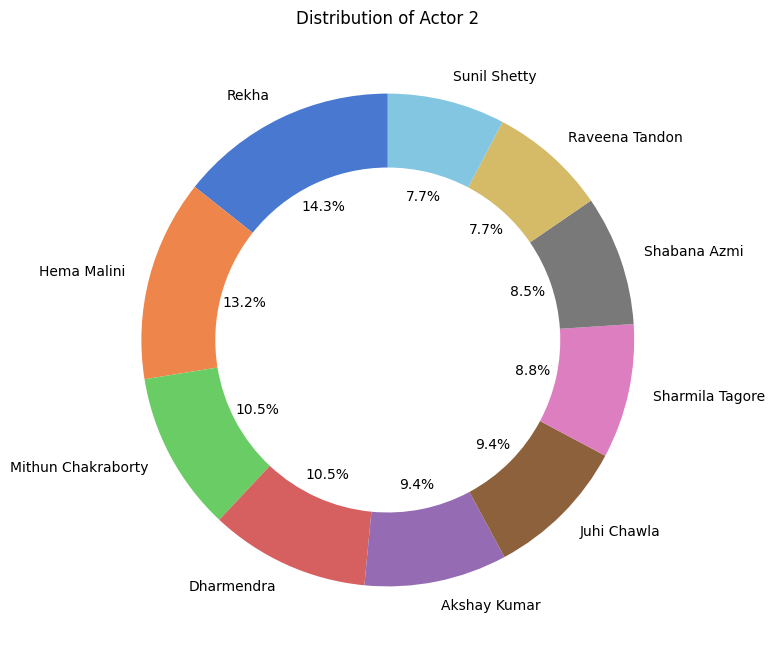

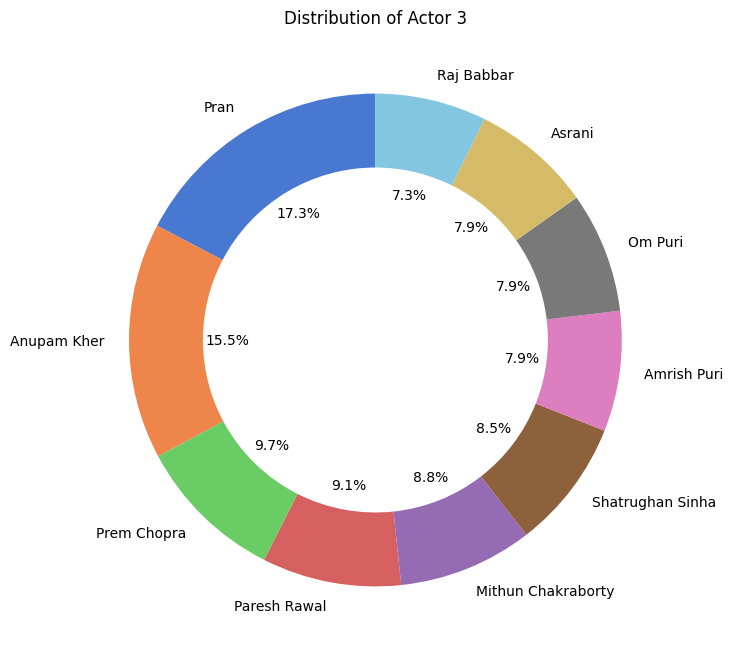

In [130]:
def plot_pie_chart(column):
    plt.figure(figsize=(8, 8))
    df[column].value_counts().head(10).plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('muted'), wedgeprops=dict(width=0.3))
    plt.title(f'Distribution of {column}')
    plt.ylabel('')
    plt.show()


def plot_hist_chart(column):
    plt.figure(figsize=(10, 5))
    df[column].hist()
    plt.title(f'{column} Distribution')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()

for col in df.columns:
    if df[col].dtype == 'object':
        plot_pie_chart(col)
    else:
        plot_hist_chart(col)

In [131]:
df["Duration"] = df.loc[:,"Duration"].str.replace(" min","")
df["Duration"] = pd.to_numeric(df.loc[:,"Duration"])
df["Votes"] = df.loc[:,"Votes"].str.replace(",","")
df["Votes"] = pd.to_numeric(df.loc[:,"Votes"])

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5659 non-null   object 
 1   Year      5659 non-null   object 
 2   Duration  5659 non-null   int64  
 3   Genre     5659 non-null   object 
 4   Rating    5659 non-null   float64
 5   Votes     5659 non-null   int64  
 6   Director  5659 non-null   object 
 7   Actor 1   5659 non-null   object 
 8   Actor 2   5659 non-null   object 
 9   Actor 3   5659 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 486.3+ KB


In [133]:
df.duplicated(subset=["Name","Year"]).sum()

2

In [134]:
df = df.drop_duplicates(keep="first",subset=["Name","Year"]).reset_index(drop=True)

In [135]:
df["Year"] = df.loc[:,"Year"].str.extract(r"(\d{4})")
df["Year"] = pd.to_numeric(df.loc[:,"Year"])

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5657 entries, 0 to 5656
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5657 non-null   object 
 1   Year      5657 non-null   int64  
 2   Duration  5657 non-null   int64  
 3   Genre     5657 non-null   object 
 4   Rating    5657 non-null   float64
 5   Votes     5657 non-null   int64  
 6   Director  5657 non-null   object 
 7   Actor 1   5657 non-null   object 
 8   Actor 2   5657 non-null   object 
 9   Actor 3   5657 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 442.1+ KB


In [137]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
2,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
3,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
4,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [138]:
director_avg_rating = {}
for index, row in df.iterrows():
    director = row['Director']
    rating = row['Rating']
    if director in director_avg_rating:
        director_avg_rating[director]['sum'] += rating
        director_avg_rating[director]['count'] += 1
    else:
        director_avg_rating[director] = {'sum': rating, 'count': 1}

df['director_average_rating'] = df['Director'].apply(lambda x: director_avg_rating[x]['sum'] / director_avg_rating[x]['count'])

In [139]:
actor_avg_rating = {}
for index, row in df.iterrows():
    actors = row['Actor 1'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}

def calculate_actor1_average(row):
    actors = row['Actor 1'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

df['actor1_average_rating'] = df.apply(calculate_actor1_average, axis=1)

In [140]:
actor_avg_rating = {}
for index, row in df.iterrows():
    actors = row['Actor 2'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}

def calculate_actor2_average(row):
    actors = row['Actor 2'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

df['actor2_average_rating'] = df.apply(calculate_actor2_average, axis=1)

In [141]:
actor_avg_rating = {}
for index, row in df.iterrows():
    actors = row['Actor 3'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}

def calculate_actor3_average(row):
    actors = row['Actor 3'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

df['actor3_average_rating'] = df.apply(calculate_actor3_average, axis=1)

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5657 entries, 0 to 5656
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     5657 non-null   object 
 1   Year                     5657 non-null   int64  
 2   Duration                 5657 non-null   int64  
 3   Genre                    5657 non-null   object 
 4   Rating                   5657 non-null   float64
 5   Votes                    5657 non-null   int64  
 6   Director                 5657 non-null   object 
 7   Actor 1                  5657 non-null   object 
 8   Actor 2                  5657 non-null   object 
 9   Actor 3                  5657 non-null   object 
 10  director_average_rating  5657 non-null   float64
 11  actor1_average_rating    5657 non-null   float64
 12  actor2_average_rating    5657 non-null   float64
 13  actor3_average_rating    5657 non-null   float64
dtypes: float64(5), int64(3),

In [143]:
df['Genre'].nunique()

376

In [144]:
df['Genre'].unique()

array(['Drama', 'Comedy, Romance', 'Comedy, Drama, Musical',
       'Drama, Romance, War', 'Horror, Mystery, Thriller',
       'Action, Crime, Thriller', 'Horror', 'Horror, Romance, Thriller',
       'Comedy, Drama, Romance', 'Comedy, Drama', 'Crime, Drama, Mystery',
       'Horror, Thriller', 'Comedy, Horror', 'Drama, Horror, Mystery',
       'Action, Thriller', 'Action', 'Horror, Mystery, Romance',
       'Horror, Mystery', 'Drama, Horror, Romance',
       'Action, Drama, History', 'Action, Drama, War', 'Thriller',
       'Comedy', 'Adventure, Horror, Mystery', 'Action, Sci-Fi',
       'Crime, Mystery, Thriller', 'Drama, History', 'Sport',
       'Biography, Drama, History', 'Horror, Romance', 'Crime, Drama',
       'Adventure, Drama', 'Comedy, Mystery, Thriller', 'Drama, Romance',
       'Crime, Thriller', 'Horror, Sci-Fi, Thriller',
       'Drama, Mystery, Thriller', 'Drama, Family, Musical',
       'Action, Comedy', 'Action, Adventure, Fantasy', 'Documentary',
       'Drama, Horro

In [145]:
df['Genre1'] = df.Genre.str.split(', ',expand=True)[0]
df['Genre2'] = df.Genre.str.split(', ',expand=True)[1]
df['Genre3'] = df.Genre.str.split(', ',expand=True)[2]

In [146]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,director_average_rating,actor1_average_rating,actor2_average_rating,actor3_average_rating,Genre1,Genre2,Genre3
0,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,7.000000,6.850000,7.000000,7.000000,Drama,None,None
1,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,4.400000,5.420000,4.400000,4.450000,Comedy,Romance,None
2,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,5.313333,4.788889,5.786667,5.872727,Comedy,Drama,Musical
3,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,7.383333,5.435000,6.933333,6.500000,Drama,Romance,War
4,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,5.600000,5.600000,5.883333,5.600000,Horror,Mystery,Thriller


In [147]:
df['Genre1'] = df['Genre1'].replace('Musical', 'Music')
df['Genre2'] = df['Genre2'].replace('Musical', 'Music')
df['Genre3'] = df['Genre3'].replace('Musical', 'Music')

In [148]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,director_average_rating,actor1_average_rating,actor2_average_rating,actor3_average_rating,Genre1,Genre2,Genre3
0,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,7.000000,6.850000,7.000000,7.000000,Drama,None,None
1,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,4.400000,5.420000,4.400000,4.450000,Comedy,Romance,None
2,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,5.313333,4.788889,5.786667,5.872727,Comedy,Drama,Music
3,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,7.383333,5.435000,6.933333,6.500000,Drama,Romance,War
4,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,5.600000,5.600000,5.883333,5.600000,Horror,Mystery,Thriller


In [149]:
df.isnull().sum()

Name                          0
Year                          0
Duration                      0
Genre                         0
Rating                        0
Votes                         0
Director                      0
Actor 1                       0
Actor 2                       0
Actor 3                       0
director_average_rating       0
actor1_average_rating         0
actor2_average_rating         0
actor3_average_rating         0
Genre1                        0
Genre2                     1657
Genre3                     3339
dtype: int64

In [150]:
df = df.fillna(0)

In [151]:
df.isnull().sum()

Name                       0
Year                       0
Duration                   0
Genre                      0
Rating                     0
Votes                      0
Director                   0
Actor 1                    0
Actor 2                    0
Actor 3                    0
director_average_rating    0
actor1_average_rating      0
actor2_average_rating      0
actor3_average_rating      0
Genre1                     0
Genre2                     0
Genre3                     0
dtype: int64

In [152]:
for i in df.index:
    if df.at[i, 'Genre2'] == 0:
        df.at[i, 'Genre2'] = df.at[i, 'Genre1']
    if df.at[i, 'Genre3'] == 0:
        df.at[i, 'Genre3'] = df.at[i, 'Genre2']

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5657 entries, 0 to 5656
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     5657 non-null   object 
 1   Year                     5657 non-null   int64  
 2   Duration                 5657 non-null   int64  
 3   Genre                    5657 non-null   object 
 4   Rating                   5657 non-null   float64
 5   Votes                    5657 non-null   int64  
 6   Director                 5657 non-null   object 
 7   Actor 1                  5657 non-null   object 
 8   Actor 2                  5657 non-null   object 
 9   Actor 3                  5657 non-null   object 
 10  director_average_rating  5657 non-null   float64
 11  actor1_average_rating    5657 non-null   float64
 12  actor2_average_rating    5657 non-null   float64
 13  actor3_average_rating    5657 non-null   float64
 14  Genre1                  

In [154]:
df = df.drop(columns=['Name','Genre','Director','Actor 1','Actor 2','Actor 3'])

In [155]:
unique_genre = set(df['Genre1'].unique()) | set(df['Genre2'].unique()) | set(df['Genre3'].unique())
genre_to_int = {genre: idx for idx, genre in enumerate(unique_genre)}

df['Genre1'] = df['Genre1'].map(genre_to_int)
df['Genre2'] = df['Genre2'].map(genre_to_int)
df['Genre3'] = df['Genre3'].map(genre_to_int)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5657 entries, 0 to 5656
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     5657 non-null   int64  
 1   Duration                 5657 non-null   int64  
 2   Rating                   5657 non-null   float64
 3   Votes                    5657 non-null   int64  
 4   director_average_rating  5657 non-null   float64
 5   actor1_average_rating    5657 non-null   float64
 6   actor2_average_rating    5657 non-null   float64
 7   actor3_average_rating    5657 non-null   float64
 8   Genre1                   5657 non-null   int64  
 9   Genre2                   5657 non-null   int64  
 10  Genre3                   5657 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 486.3 KB


In [157]:
X = df.drop(columns=['Rating'])
Y = df['Rating']

In [158]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [159]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [160]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
    }

    xgb = XGBRegressor(**param)
    xgb.fit(X_train, Y_train)
    y_pred = xgb.predict(X_test)
    r2 = r2_score(Y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

best_params = best_trial.params

[I 2024-07-07 15:29:10,610] A new study created in memory with name: no-name-cfcabf58-e6c5-4039-930f-a79846644a58
[I 2024-07-07 15:29:16,681] Trial 0 finished with value: 0.8370603130396996 and parameters: {'n_estimators': 326, 'max_depth': 10, 'learning_rate': 0.08128861432327794, 'subsample': 0.7615826307921588, 'colsample_bytree': 0.8153990573224299, 'reg_alpha': 2.0383300429998386, 'reg_lambda': 2.112092748782114}. Best is trial 0 with value: 0.8370603130396996.
[I 2024-07-07 15:29:27,685] Trial 1 finished with value: 0.8454916985801374 and parameters: {'n_estimators': 356, 'max_depth': 10, 'learning_rate': 0.05766209262507778, 'subsample': 0.7372215898591582, 'colsample_bytree': 0.9669318943759606, 'reg_alpha': 6.317184688628568, 'reg_lambda': 3.115860666015423}. Best is trial 1 with value: 0.8454916985801374.
[I 2024-07-07 15:29:37,874] Trial 2 finished with value: 0.8474631715177506 and parameters: {'n_estimators': 860, 'max_depth': 7, 'learning_rate': 0.0331101044239609, 'subsa

Best trial:
  Value: 0.854173583097335
  Params: 
    n_estimators: 550
    max_depth: 4
    learning_rate: 0.05203514711852474
    subsample: 0.9859353837833668
    colsample_bytree: 0.9895041054457868
    reg_alpha: 3.5472941467162755
    reg_lambda: 3.614281868435766


In [161]:
best_params

{'n_estimators': 550,
 'max_depth': 4,
 'learning_rate': 0.05203514711852474,
 'subsample': 0.9859353837833668,
 'colsample_bytree': 0.9895041054457868,
 'reg_alpha': 3.5472941467162755,
 'reg_lambda': 3.614281868435766}

In [162]:
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train, Y_train,eval_set=[(X_train, Y_train), (X_test,Y_test)],verbose=0)
Y_pred = xgb_model.predict(X_test)

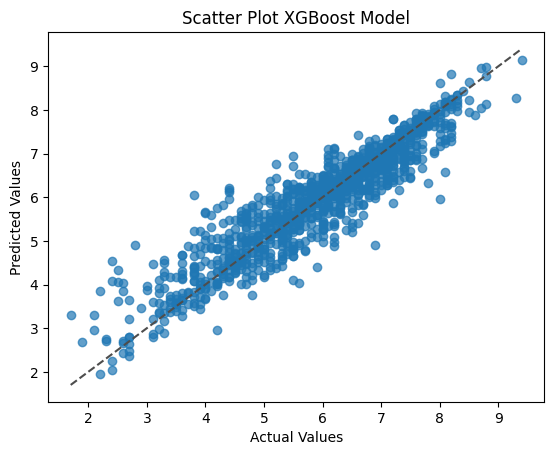

In [163]:
plt.scatter(Y_test, Y_pred, alpha=0.7, label='Real')
plt.plot([Y_test.min(), Y_test.max()],[Y_test.min(), Y_test.max()], '--', c='.3')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot XGBoost Model')
plt.show()

In [164]:
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']